# Exploring relationships among categorical variables

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [3]:
!wget -nc -P .local_data https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data

--2021-12-14 20:29:28--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3974305 (3.8M) [application/x-httpd-php]
Saving to: '.local_data/adult.data'

adult.data          100%[===================>]   3.79M  7.80MB/s    in 0.5s    

2021-12-14 20:29:29 (7.80 MB/s) - '.local_data/adult.data' saved [3974305/3974305]



In [5]:
cols = ['age', 'workclass', 'fnlwgt', 'education', 'educ_num',
        'marital_status', 'occupation', 'relationship', 'race',
        'sex', 'capgain', 'caploss', 'hours', 'country',
        'income']
df = pd.read_csv('.local_data/adult.data', names=cols)
df.shape

(32561, 15)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   educ_num        32561 non-null  int64 
 5   marital_status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capgain         32561 non-null  int64 
 11  caploss         32561 non-null  int64 
 12  hours           32561 non-null  int64 
 13  country         32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [7]:
# Clean up leading and trailing whitespace
obj_cols = ['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'country', 'income']
for c in obj_cols:
    df[c] = df[c].str.strip()

In [8]:
# Drop rows having '?' in any attribute
bdf = (df == '?')
badrows = bdf.any(axis=1)
df = df.drop(badrows[badrows==True].index)

In [9]:
df.sample(3)

,age,workclass,fnlwgt,education,educ_num,marital_status,occupation,relationship,race,sex,capgain,caploss,hours,country,income
24611,46,Private,191204,Assoc-voc,11,Never-married,Exec-managerial,Own-child,White,Female,0,0,40,United-States,<=50K
21120,32,Private,27856,Some-college,10,Never-married,Adm-clerical,Not-in-family,White,Female,0,0,40,United-States,<=50K
31052,20,Private,190227,Masters,14,Never-married,Exec-managerial,Own-child,White,Male,0,0,25,United-States,<=50K


## Multivariate analysis: categorical vs. categorical

### Two-way table

Two-way frequency tables, also called contingency tables or confusion matrices, are tables of counts with two dimensions where each dimension is a different variable. Two-way tables can give you insight into the relationship between two variables.

In [10]:
twowayct = pd.crosstab(index=df['relationship'], columns=df['sex'], margins=False)
twowayct

sex,Female,Male
relationship,,
Husband,1,12462
Not-in-family,3566,4160
Other-relative,386,503
Own-child,1961,2505
Unmarried,2463,749
Wife,1405,1


### Histograms by category
Side by side histograms let you compare the distributions of an attribute by category.

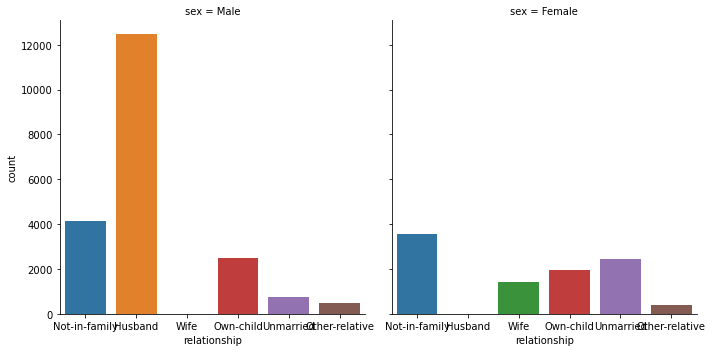

In [11]:
sns.catplot(data=df, x='relationship', col='sex', kind='count')
plt.tight_layout()
plt.show()

Stacked bars/histograms are not too intuitive in Matplotlib, but can be done.

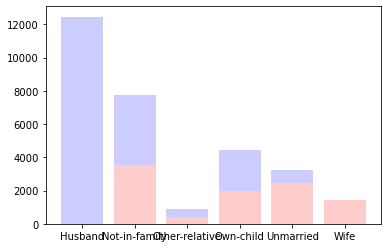

In [12]:
plt.bar(twowayct.index.values, twowayct.Female.values, color='#ffcccc')
plt.bar(twowayct.index.values, twowayct.Male.values, color='#ccccff', bottom=twowayct.Female.values)
plt.show()

### $\chi^{2}$ test for independence

We can use the $\chi^{2}$ test to determine whether an association (or relationship) between two categorical variables is significant. (Note: this test will not give us a sense of the size/strength or direction of the relationship.)

* p=0 $\rightarrow$ The variables are interdependent
* p=1 $\rightarrow$ The variables are independent
* p=0.05 $\rightarrow$ There is a significant relationship at 95% confidence level

In [13]:
row_totals = twowayct.agg(sum, axis=1).values
col_totals = twowayct.agg(sum, axis=0).values

In [14]:
row_totals, col_totals

(array([12463,  7726,   889,  4466,  3212,  1406]), array([ 9782, 20380]))

In [15]:
twowayct.columns.values

array(['Female', 'Male'], dtype=object)

In [16]:
# Compute the expected values
N = sum(row_totals) # or sum(col_totals) -- total number of records
expected =  np.outer(row_totals, col_totals) / N # outer product divided by N

# The rest is just for pretty formatting
expected = pd.DataFrame(expected)
expected.columns = twowayct.columns.values
expected.index = twowayct.index.values
expected

,Female,Male
Husband,4041.942378,8421.057622
Not-in-family,2505.660500,5220.339500
Other-relative,288.316358,600.683642
Own-child,1448.392414,3017.607586
Unmarried,1041.700948,2170.299052
Wife,455.987401,950.012599


In [17]:
from scipy.stats import chisquare
c, p = chisquare(twowayct, expected)
c, p

(array([8617.50268296, 4136.23215136]), array([0., 0.]))

#### Explanation

The null hypothesis $H_0$ is that there is no relationship between the two variables.

The p-value of 0 leads us to reject the null hypothesis. In other words, we conclude that
there is evidence to suggest a relationship between `sex` and `relationship`.

The nature and scale of this relationship is not known at this point. If we want to understand
the effect SIZE, we could apply Cramér's V. (Do not try this at home.)

## Multivariate analysis: categorical vs. continuous

### Box plots (or similar) by category

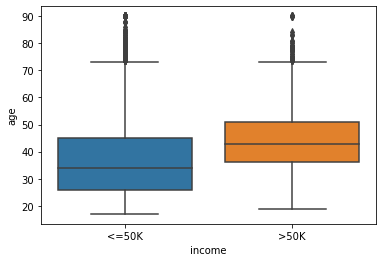

In [18]:
sns.boxplot(x=df['income'], y=df['age'])
plt.show()

### Difference of means (binary categorical)
Calculate the T-test for the means of two independent samples.

In [19]:
from scipy.stats import ttest_ind

In [20]:
ttest_ind(df[df['income']=='<=50K']['age'], df[df['income']=='>50K']['age'])

Ttest_indResult(statistic=-43.31437788497932, pvalue=0.0)

#### Explanation

The null hypothesis is that the two distributions have equal means.

Since the p-value is very small, we reject the null hypothesis.

According to this test, these two groups represent different populations. In other words,
the age distributions among people in the higher income differs meaningfully from that of the lower income group.

This should not come as a shock, but if you're still not convinced let's look at violin plots:

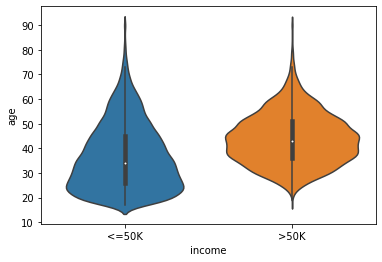

In [21]:
sns.violinplot(x=df['income'], y=df['age'])
plt.show()

### ANOVA

Test for difference of means among several groups of continuous values.

$H_0$: two or more groups have the same population mean.

In [22]:
from scipy.stats import f_oneway
# null hypothesis: two or more groups have the same population mean

In [23]:
# A contrived example using three normally distributed lists of values
x = np.random.normal(0,1,200)
y = np.random.normal(0,1,100)
z = np.random.normal(0,1,300)
f_oneway(x, y, z)

F_onewayResult(statistic=0.046406087888045115, pvalue=0.9546576532738937)

Since the p-value is “large”, we fail to reject the null hypothesis. That is, we conclude
that there is strong evidence that the three distributions have the same mean.

Notice that the groups do not have to be the same size.

In [24]:
# Now let's try it with five columns from our dataset
acols = ['age', 'fnlwgt', 'capgain', 'caploss', 'hours']
f_oneway(*df[acols].T.values)

F_onewayResult(statistic=96537.33623715355, pvalue=0.0)

We reject $H_0$, concluding that these groups do not have the same population mean.

In [25]:
# One more time, one attribute grouped by race
X = []
for r in df['race'].unique():
    xr = df[df['race']==r]['age']
    X.append(xr) # append to X
# X is a list of lists, each of different length

In [26]:
f_oneway(*X)

F_onewayResult(statistic=11.528499338047334, pvalue=2.3698800718814655e-09)

This result suggests that the distribution of `age` does not vary significantly with race.

Let's plot the distributions and see if that seems right.

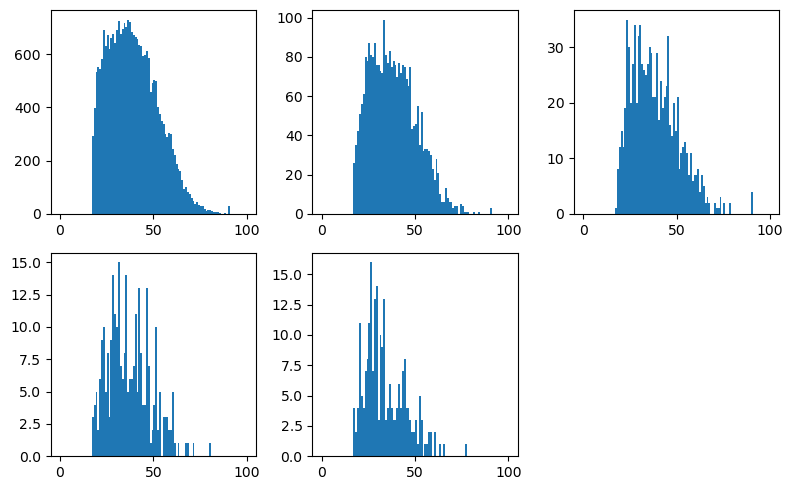

In [27]:
fig = plt.figure(figsize=(8,5), dpi=100)
N = len(X)
for n in range(N):
    ax = plt.subplot(2, 3, n+1)
    #c = pcols[n]
    #ax.set_title('{}\nskew={:.3f}\nkurtosis={:.3f}'.format(c, skew(prob[c]), kurtosis(prob[c])))
    ax.hist(X[n], range=(0,100), bins=100)
plt.tight_layout()
plt.show()

### Correspondence Analysis (CA)

Assess the dependencies between two categorical variables

Let's consider two categorical attributes with several possible values each.
We'll generate a contingency table, which shows the number of records in which
two corresponding levels occur.

In [28]:
# Let's create a new attribute to represent education attainment
edmap = {
    '5th-6th': '<HS',
    'Preschool': '<HS',
    '1st-4th': '<HS',
    '7th-8th': '<HS',
    '9th': '<HS',
    '10th': '<HS',
    '11th': '<HS',
    '12th': '<HS',
    'HS-grad': 'HS',
    'Some-college': 'HS',
    'Assoc-acdm': 'AS',
    'Assoc-voc': 'AS',
    'Bachelors': 'BS',
    'Masters': 'Adv',
    'Doctorate': 'Adv',
    'Prof-school': 'Adv'
}
df['edlevel'] = df['education'].map(edmap)

In [29]:
# Here are two categorical attributes with several levels each
ct = pd.crosstab(df['race'], df['edlevel'])
ct

edlevel,<HS,AS,Adv,BS,HS
race,,,,,
Amer-Indian-Eskimo,47,23,9,20,187
Asian-Pac-Islander,75,62,142,252,364
Black,459,208,101,301,1748
Other,71,14,10,23,113
White,3089,2008,2282,4448,14106


It's very difficult to look at that table and see whether there exists a dependent relationship
between these two variables! We can use *Correspondence Analysis (CA)* to assess the relationship
between two categorical attributes.

First, we'll need the [Prince](https://github.com/MaxHalford/prince) package installed.

```
pip install prince
```

In [30]:
# Here are two categorical attributes with several levels each
ct = pd.crosstab(df['sex'], df['occupation'])
ct

occupation,Adm-clerical,Armed-Forces,Craft-repair,Exec-managerial,Farming-fishing,Handlers-cleaners,Machine-op-inspct,Other-service,Priv-house-serv,Prof-specialty,Protective-serv,Sales,Tech-support,Transport-moving
sex,,,,,,,,,,,,,,
Female,2512,0,216,1143,65,164,543,1758,135,1491,76,1248,341,90
Male,1209,9,3814,2849,924,1186,1423,1454,8,2547,568,2336,571,1482


In [32]:
from prince import CA
ca = CA(
    n_components=2,
    n_iter=3,
    copy=True,
    engine='auto'
)
ca = ca.fit(ct)

<Figure size 500x500 with 0 Axes>

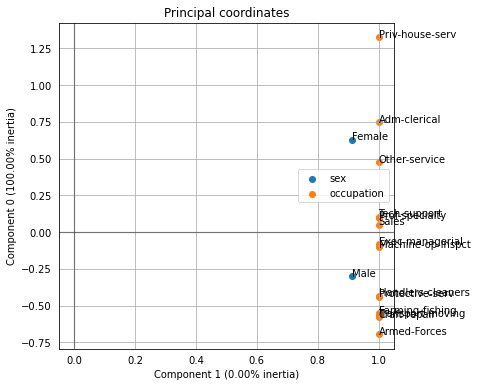

In [33]:
fig = plt.figure(figsize=(5,5), dpi=100)
plt.sca(ca.plot_coordinates(
    X=ct,
    x_component=1,
    y_component=0,
    show_row_labels=True,
    show_col_labels=True
))
plt.show()

### Multiple Correspondence Analysis (MCA)

for analyzing relationships among more than two categoricals; basically PCA for categoricals

In [34]:
from prince import MCA

In [35]:
df.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'educ_num', 'marital_status',
       'occupation', 'relationship', 'race', 'sex', 'capgain', 'caploss',
       'hours', 'country', 'income', 'edlevel'],
      dtype='object')

In [36]:
#categ_cols = ['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'country', 'income']
categ_cols = ['workclass', 'education', 'race', 'sex']
mca = MCA(
    n_components=2,
    n_iter=10,
    copy=True,
    check_input=True,
    engine='auto'
)
mca = mca.fit(df[categ_cols])

In [37]:
mca

MCA()

<Figure size 500x500 with 0 Axes>

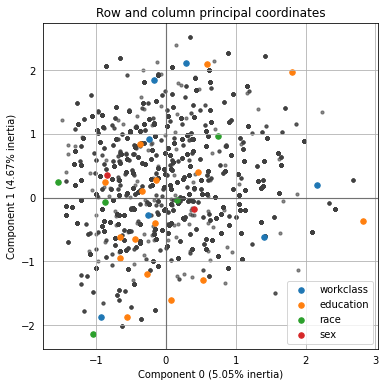

In [38]:
fig = plt.figure(figsize=(5,5), dpi=100)
ax = mca.plot_coordinates(
    X=df[categ_cols],
    ax=None,
    show_row_points=True,
    row_points_size=10,
    show_row_labels=False,
    show_column_points=True,
    column_points_size=30,
    show_column_labels=False,
    legend_n_cols=1
)
plt.show()

No clear relationships among ALL the categoricals, so let's narrow it down.